In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import copy
import mytools

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
# runs 6 and 7 are ANN_relu_sig, lambda = 200
# run 9 is ANN_relu_sig, lambda = 100
# run 8 is ANN_relu_sig_orig, lambda = 100 // orig means that the adversary training loop is nested in the classifier's training loop
# run 10 is ANN_relu_sig_orig, lambda = 100, tested on 99% selection & 1st half of test data set only
# run 11 is ANN_relu_sig_orig_corr, lambda = 100, tested with corr coef & 1st half of test data set only
# run 12 is ANN_relu_sig_orig_valloss, lambda = 100, tested with validation loss for stopping (test set untouched)
# run 13 is ANN_relu_sig_orig_50epochs, lambda = 100

# so far 6 and 7 are the best
run = "7"

In [3]:
bdt_results = pd.read_pickle("/Users/mghrear/data/ML_data/BDT_results.pk")
ANN_results = pd.read_pickle("/Users/mghrear/data/ML_data/ANN_results_relu_"+run+".pk")

ANN_results['BDT']=bdt_results['Yhat']

ANN_results.head()

,vertex_pos_x,vertex_pos_y,vertex_pos_z,ele_E_Ecal,pos_E_Ecal,ele_Ecal_nhits,pos_Ecal_nhits,ele_Ecal_x,ele_Ecal_y,ele_Ecal_z,...,pos_dp,pos_kappa_o_alpha,pos_dz,pos_tan_lambda,PhiKK,type,InvM,Class_pre,Class_adv,BDT
0,0.367547,0.011885,-8.167375,0.000000,1.326186,-1.0,8.0,-9999.000000,-9999.000000,-9999.000000,...,0.038248,0.000192,0.422488,0.045401,0.0,tritrig,0.992347,0.003137,0.003085,0.338690
1,-0.825487,0.099924,-10.598491,0.000000,1.486202,-1.0,7.0,-9999.000000,-9999.000000,-9999.000000,...,-0.731331,0.000133,-0.298660,-0.015215,0.0,tritrig,1.092728,0.006039,0.010506,0.287172
2,0.393670,0.032501,-6.033850,0.661477,1.491288,5.0,7.0,-160.779404,-34.624546,1449.943115,...,0.681222,0.000145,-0.193928,-0.023157,0.0,tritrig,0.993269,0.237625,0.757615,0.439947
3,0.184817,0.022278,-7.631687,1.767747,2.143450,5.0,12.0,-179.772842,-44.783043,1450.051147,...,0.648233,0.000117,-0.322772,-0.035475,0.0,tritrig,1.007855,0.007729,0.015359,0.370086
4,-0.078719,0.029014,-8.910273,1.420213,0.992165,4.0,4.0,-204.517853,-26.922096,1450.047485,...,0.114762,0.000182,-0.207398,-0.016264,0.0,tritrig,0.990232,0.002738,0.008395,0.260610


# Compare Classifiers on testing data

In [4]:
# Split into tritrig and phiKK dataframes
test_df_tritrig = ANN_results[ANN_results['type']=="tritrig"].reset_index(drop=True)
test_df_phiKK = ANN_results[ANN_results['type']=="phiKK"].reset_index(drop=True)
test_df_wab = ANN_results[ANN_results['type']=="wab"].reset_index(drop=True)
test_df_bkg = pd.concat([test_df_tritrig,test_df_wab])



Test AUROC: 0.9981


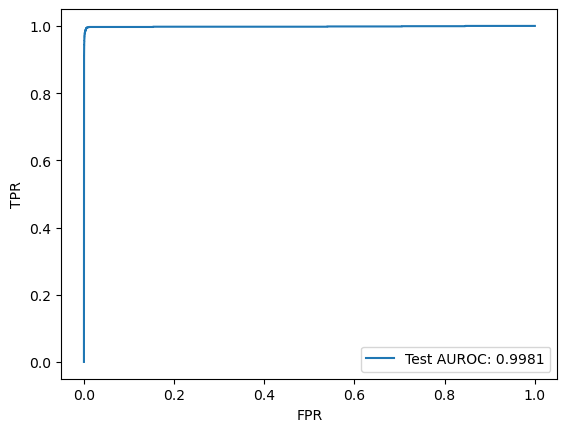

In [5]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(ANN_results.PhiKK, ANN_results.BDT, pos_label=1)
auc_test = sklearn.metrics.auc(fpr, tpr)
print(f'Test AUROC: {auc_test:0.4f}')

plt.plot(fpr, tpr, label=f'Test AUROC: {auc_test:0.4f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

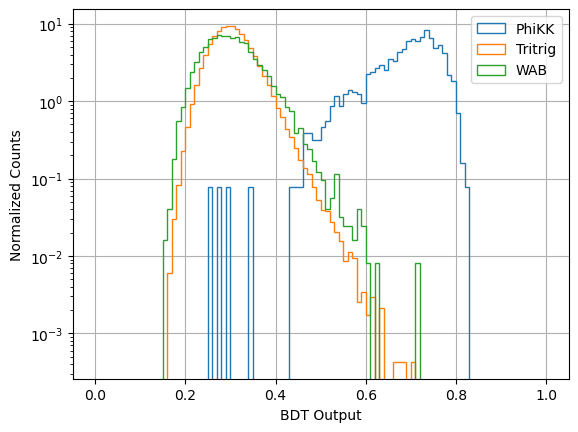

In [6]:
test_df_phiKK.BDT.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='PhiKK',density=True)
test_df_tritrig.BDT.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='Tritrig',density=True)
test_df_wab.BDT.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='WAB',density=True)
#plt.axvline(x=0.4, color='k', linestyle='--', label ="selection line")
plt.xlabel('BDT Output')
plt.ylabel('Normalized Counts')
plt.yscale('log')
plt.legend()

Test AUROC: 0.9942


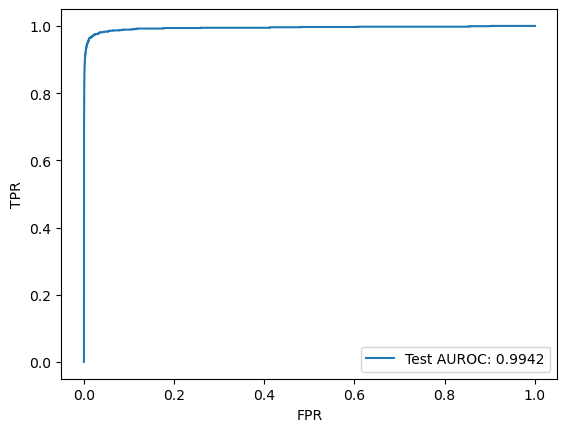

In [7]:

fpr, tpr, thresholds = sklearn.metrics.roc_curve(ANN_results.PhiKK, ANN_results.Class_pre, pos_label=1)
auc_test = sklearn.metrics.auc(fpr, tpr)
print(f'Test AUROC: {auc_test:0.4f}')

plt.plot(fpr, tpr, label=f'Test AUROC: {auc_test:0.4f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()


In [8]:
a =tpr/fpr

masked = np.ma.masked_invalid(a) # masks inf and nan
if masked.count() == 0: raise ValueError("No finite values")
idx = masked.argmax()

thresholds[idx]

/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_76697/3384453741.py:1: RuntimeWarning: invalid value encountered in divide
  a =tpr/fpr


np.float64(0.991079569798686)

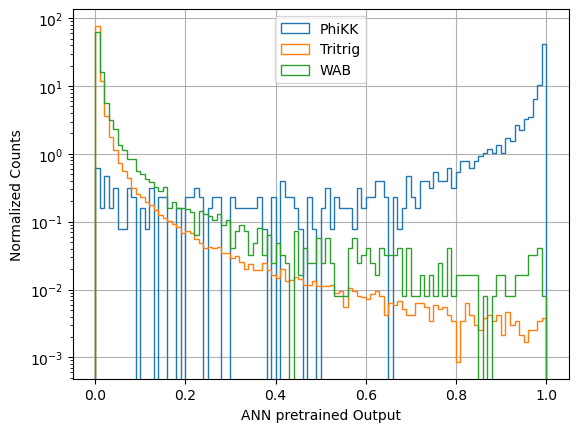

In [9]:
test_df_phiKK.Class_pre.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='PhiKK',density=True)
test_df_tritrig.Class_pre.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='Tritrig',density=True)
test_df_wab.Class_pre.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='WAB',density=True)
plt.yscale('log')
plt.xlabel('ANN pretrained Output')
plt.ylabel('Normalized Counts')
plt.legend()

Test AUROC: 0.9915


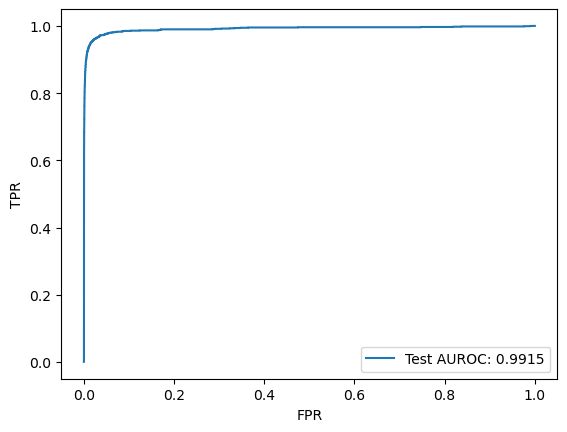

In [10]:

fpr, tpr, thresholds = sklearn.metrics.roc_curve(ANN_results.PhiKK, ANN_results.Class_adv, pos_label=1)
auc_test = sklearn.metrics.auc(fpr, tpr)
print(f'Test AUROC: {auc_test:0.4f}')

plt.plot(fpr, tpr, label=f'Test AUROC: {auc_test:0.4f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()


In [11]:
a =tpr/fpr

masked = np.ma.masked_invalid(a) # masks inf and nan
if masked.count() == 0: raise ValueError("No finite values")
idx = masked.argmax()

thresholds[idx]

/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_76697/3384453741.py:1: RuntimeWarning: invalid value encountered in divide
  a =tpr/fpr


np.float64(0.9958845904891236)

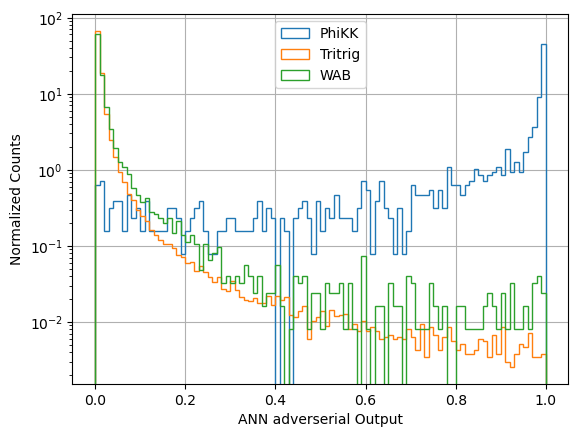

In [12]:
test_df_phiKK.Class_adv.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='PhiKK',density=True)
test_df_tritrig.Class_adv.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='Tritrig',density=True)
test_df_wab.Class_adv.hist(bins=np.arange(0,1.01,0.01), histtype='step', label='WAB',density=True)
plt.yscale('log')
plt.xlabel('ANN adverserial Output')
plt.ylabel('Normalized Counts')
plt.legend()

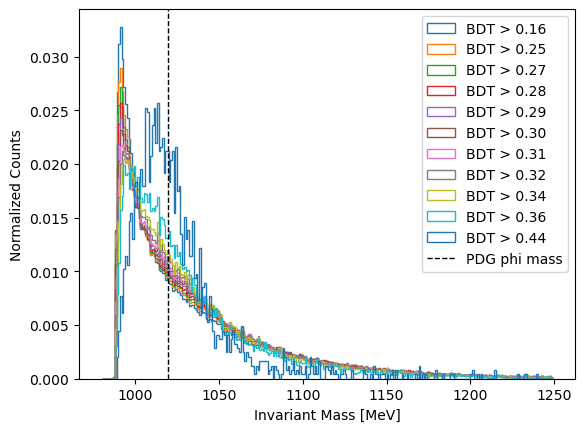

In [13]:
for sel in np.percentile(test_df_bkg['BDT'],[0,10,20,30,40,50,60,70,80,90,99]):

    df_tritrig_cut = test_df_bkg[test_df_bkg['BDT']>sel].reset_index(drop=True)

    x_vals = 1000*df_tritrig_cut.InvM

    plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step', label=f'BDT > {sel:.2f}', density=True)


plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Normalized Counts')
plt.legend()

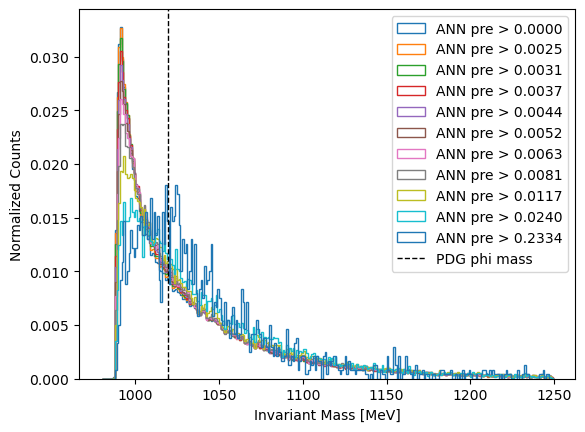

In [14]:
for sel in  np.percentile(test_df_bkg['Class_pre'],[0,10,20,30,40,50,60,70,80,90,99]):

    df_tritrig_cut = test_df_bkg[test_df_bkg['Class_pre']>sel].reset_index(drop=True)

    x_vals = 1000*df_tritrig_cut.InvM

    plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step', label=f'ANN pre > {sel:.4f}', density=True)


plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Normalized Counts')
plt.legend()

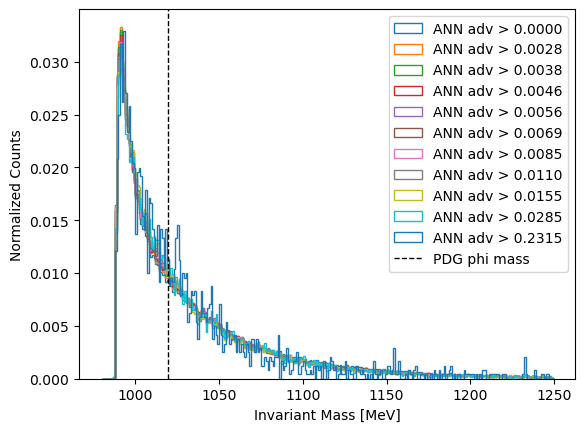

In [15]:
for sel in np.percentile(test_df_bkg['Class_adv'],[0,10,20,30,40,50,60,70,80,90,99]):

    df_tritrig_cut = test_df_bkg[test_df_bkg['Class_adv']>sel].reset_index(drop=True)

    x_vals = 1000*df_tritrig_cut.InvM

    plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step', label=f'ANN adv > {sel:.4f}', density=True)


plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Normalized Counts')
plt.legend()

# Compare classifiers on weighted testing data

In [19]:
# Compine dfs according to expected proportions
df_test_combined = pd.concat([test_df_tritrig[0:136165], test_df_wab, test_df_phiKK[0:103]], ignore_index=True, sort=False)

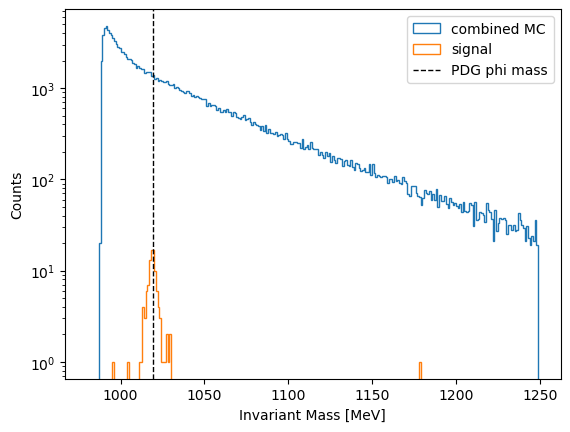

In [20]:
x_vals = 1000*df_test_combined.InvM
x_vals_sig = 1000*test_df_phiKK[0:103].InvM
plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step', label="combined MC")
plt.hist(x_vals_sig, bins=np.arange(980,1250,1), histtype='step',label="signal")
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()

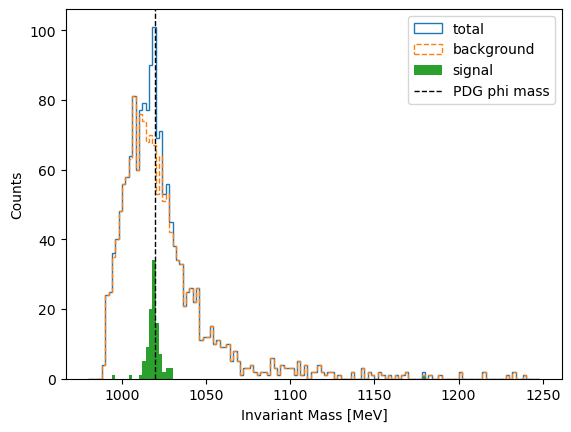

In [21]:
df_test_combined_cut = df_test_combined[df_test_combined['BDT']>np.percentile(test_df_bkg['BDT'],[99])[0]].reset_index(drop=True)
x_vals = 1000*df_test_combined_cut.InvM
x_vals_phiKK = 1000*df_test_combined_cut.loc[df_test_combined_cut.type=='phiKK'].InvM
x_bkg_vals_phiKK = 1000*df_test_combined_cut.loc[(df_test_combined_cut.type=='tritrig')|(df_test_combined_cut.type=='wab')].InvM



plt.hist(x_vals, bins=np.arange(980,1250,2), histtype='step',label="total")
plt.hist(x_bkg_vals_phiKK, bins=np.arange(980,1250,2), ls='--', histtype='step', label="background")
plt.hist(x_vals_phiKK, bins=np.arange(980,1250,2),label="signal")
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()

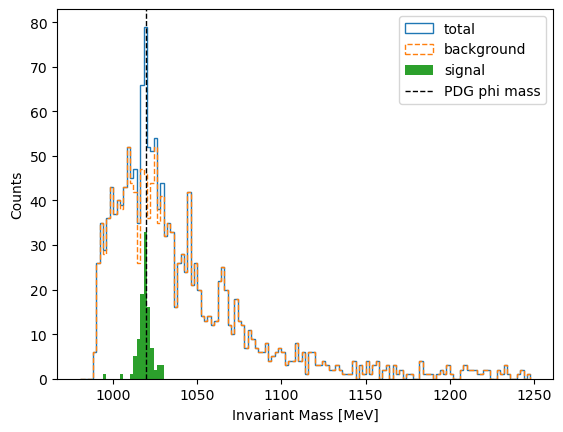

In [22]:
df_test_combined_cut = df_test_combined[df_test_combined['Class_pre']>np.percentile(test_df_bkg['Class_pre'],[99])[0]].reset_index(drop=True)
x_vals = 1000*df_test_combined_cut.InvM
x_vals_phiKK = 1000*df_test_combined_cut.loc[df_test_combined_cut.type=='phiKK'].InvM
x_bkg_vals_phiKK = 1000*df_test_combined_cut.loc[(df_test_combined_cut.type=='tritrig')|(df_test_combined_cut.type=='wab')].InvM



plt.hist(x_vals, bins=np.arange(980,1250,2), histtype='step',label="total")
plt.hist(x_bkg_vals_phiKK, bins=np.arange(980,1250,2), ls='--', histtype='step', label="background")
plt.hist(x_vals_phiKK, bins=np.arange(980,1250,2),label="signal")
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()

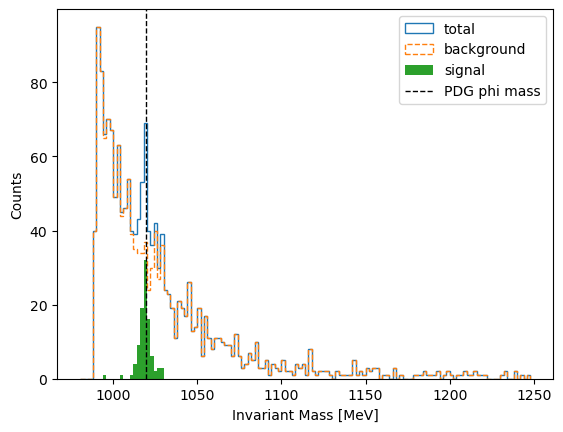

In [23]:
df_test_combined_cut = df_test_combined[df_test_combined['Class_adv']>np.percentile(test_df_bkg['Class_adv'],[99])[0]].reset_index(drop=True)
x_vals = 1000*df_test_combined_cut.InvM
x_vals_phiKK = 1000*df_test_combined_cut.loc[df_test_combined_cut.type=='phiKK'].InvM
x_bkg_vals_phiKK = 1000*df_test_combined_cut.loc[(df_test_combined_cut.type=='tritrig')|(df_test_combined_cut.type=='wab')].InvM



plt.hist(x_vals, bins=np.arange(980,1250,2), histtype='step',label="total")
plt.hist(x_bkg_vals_phiKK, bins=np.arange(980,1250,2), ls='--', histtype='step', label="background")
plt.hist(x_vals_phiKK, bins=np.arange(980,1250,2),label="signal")

plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()

# Apply ANN to data

In [24]:

X_final = pd.read_pickle('/Users/mghrear/data/ML_data/BDT_2019_data.pk')



In [228]:
# simple MLP for binary classification (single logit output)
class Classifier(nn.Module):
    def __init__(self, in_features=X_final.shape[1], hidden1=264, hidden2=264, hidden3=128, hidden4=128, hidden5=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden1,bias=False),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2,bias=False),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden3,bias=False),
            nn.BatchNorm1d(hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, hidden4,bias=False),
            nn.BatchNorm1d(hidden4),
            nn.ReLU(),
            nn.Linear(hidden4, hidden5,bias=False),
            nn.BatchNorm1d(hidden5),
            nn.ReLU(),
            nn.Linear(hidden5, 1),
        )
    def forward(self, x):
        return self.net(x)

In [229]:
final_classifier = Classifier().to(device)
final_classifier.load_state_dict(torch.load("/Users/mghrear/data/ML_data/classifier_adv_relu_"+run+".pt", map_location=device))
final_classifier.eval() 

Classifier(
  (net): Sequential(
    (0): Linear(in_features=31, out_features=264, bias=False)
    (1): BatchNorm1d(264, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=264, out_features=264, bias=False)
    (4): BatchNorm1d(264, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=264, out_features=128, bias=False)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=False)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=64, bias=False)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [230]:
final_dataset = TensorDataset(torch.from_numpy(X_final.to_numpy().astype(np.float32)) )
final_loader = DataLoader(final_dataset, batch_size=124, shuffle=False)

In [231]:
final_pred = mytools.test_final(final_loader, final_classifier, device)
final_pred=torch.sigmoid(torch.tensor(final_pred)).numpy()



Text(0, 0.5, 'Count')

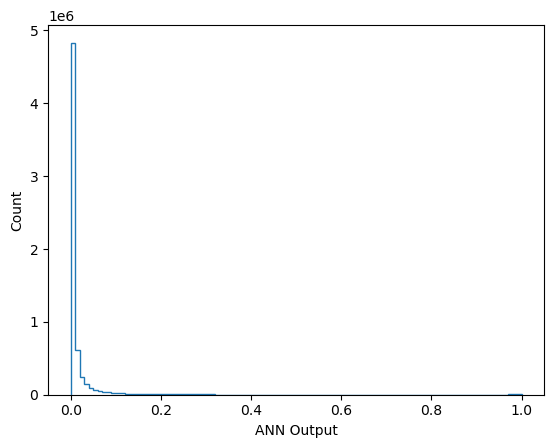

In [232]:
plt.hist(final_pred,bins=np.arange(0,1.01,0.01), histtype='step')
#plt.yscale('log')
plt.xlabel('ANN Output')
plt.ylabel('Count')

In [233]:
X_final['pred'] = final_pred
X_final['InvM'] = mytools.get_InvM(X_final)

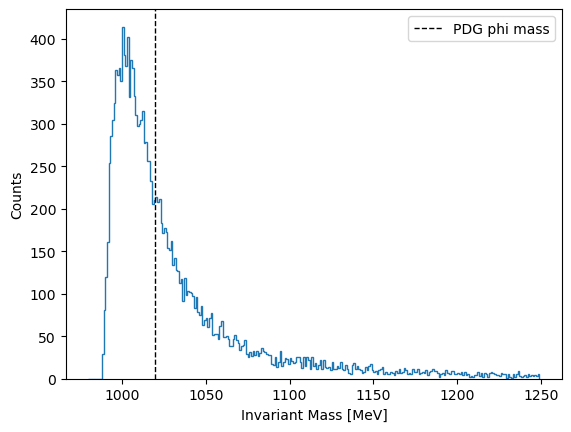

In [236]:
X_final_cut = X_final[X_final['pred']>0.95].reset_index(drop=True)
x_vals = 1000*X_final_cut.InvM

plt.hist(x_vals, bins=np.arange(980,1250,1), histtype='step')
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()



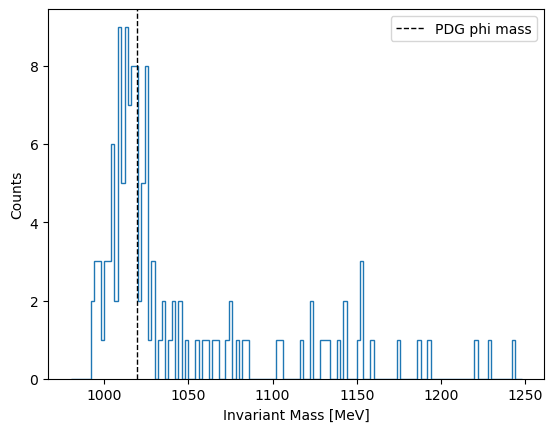

In [252]:
X_final_cut = X_final[X_final['pred']>0.9989].reset_index(drop=True)
x_vals = 1000*X_final_cut.InvM

plt.hist(x_vals, bins=np.arange(980,1250,2), histtype='step')
plt.axvline(1019.461, color='k', linestyle='dashed', linewidth=1, label='PDG phi mass')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Counts')
plt.legend()

